1. basic_statistics_tool — For Statistician Agent

In [276]:
# Explanation:
# @tool: Converts the function into a LangChain tool usable by agents.

# Takes a list of numbers and returns mean, median, and mode.

# If an error happens (e.g., empty list), it returns a friendly error.

from typing import List
from langchain_core.tools import tool
import statistics
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.graph import MessagesState
from langgraph.managed.is_last_step import RemainingSteps
from typing import TypedDict, Literal
@tool
def basic_statistics_tool(numbers: List[float]) -> str:
    """
    Calculates mean, median, and mode of a list of numbers.
    """
    try:
        mean = statistics.mean(numbers)
        median = statistics.median(numbers)
        mode = statistics.mode(numbers)
        return f"Mean: {mean}, Median: {median}, Mode: {mode}"
    except Exception as e:
        return f"Error calculating statistics: {e}"


2. trend_detection_tool — For Trend Detection Agent

In [277]:
# Explanation:
# Checks if numbers are increasing, decreasing, or stable.

# Uses simple Python logic (zip, all) — no external libraries.

@tool
def trend_detection_tool(numbers: List[float]) -> str:
    """
    Detects if the trend is increasing, decreasing, or stable.
    """
    if len(numbers) < 2:
        return "Not enough data to detect trend."

    increasing = all(x < y for x, y in zip(numbers, numbers[1:]))
    decreasing = all(x > y for x, y in zip(numbers, numbers[1:]))

    if increasing:
        return "Upward trend detected."
    elif decreasing:
        return "Downward trend detected."
    else:
        return "No clear trend detected."


3. summarize_points_tool — For Summarizer Agent

In [278]:
# Explanation:
# Breaks input text into sentences using .split('.').

# Adds - to create bullet points.

# Simple, human-readable summary.

@tool
def summarize_points_tool(text: str) -> str:
    """
    Summarizes a long text into bullet points.
    """
    sentences = text.split(".")
    bullets = [f"- {s.strip()}" for s in sentences if s.strip()]
    return "\n".join(bullets)


4. report_generation_tool — For Report Writer Agent

In [279]:
# Explanation:
# Takes a list of bullet points and wraps them inside a report format.

# Adds a professional heading and ending.

@tool
def report_generation_tool(points: List[str]) -> str:
    """
    Takes bullet points and generates a simple market research report.
    """
    intro = "📄 **Market Research Report**\n\n"
    body = "\n".join(points)
    outro = "\n\n🔚 End of Report."

    return intro + body + outro


Initialize LLM

In [280]:
from langchain_ollama import ChatOllama
ollama_model = ChatOllama(model="llama3.2")

In [281]:
ollama_model.invoke("hi")

AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-04-27T21:58:08.3598013Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1278377100, 'load_duration': 67170600, 'prompt_eval_count': 26, 'prompt_eval_duration': 2000000, 'eval_count': 8, 'eval_duration': 1180000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-64bb2dca-be03-40a9-b48d-820f19606666-0', usage_metadata={'input_tokens': 26, 'output_tokens': 8, 'total_tokens': 34})

Define Common State Class

In [282]:
# Explanation:

# MessagesState tracks all previous messages.

# next tells which agent to activate next.


class State(MessagesState):
    next: str  # Field to store the next agent to call
    remaining_steps: RemainingSteps
    

Create Agents one-by-one

1. Statistician Agent

In [283]:
# Explanation:

# Agent uses basic_statistics_tool

# Behavior is controlled by prompt ("You are a statistician…")

from langgraph.prebuilt import create_react_agent

# Create Statistician Agent
def statistician_agent_node(state: State) -> Command[Literal["supervisor"]]:
    statistician_agent = create_react_agent(
        ollama_model,
        tools=[basic_statistics_tool],
        prompt="You are a statistician. DO NOT generate summary and report.Use the provided tool to analyze numerical data and find mean, median, mode. DO NOT write summary. DO NOT generate report."
    )
    result = statistician_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="statistician")
            ]
        },
        goto="supervisor"
    )


2. Trend Detection Agent

In [284]:
# Explanation:

# Agent specializes in detecting trends from number lists.

# Create Trend Detection Agent
def trend_detection_agent_node(state: State) -> Command[Literal["supervisor"]]:
    trend_detection_agent = create_react_agent(
        ollama_model,
        tools=[trend_detection_tool],
        prompt="You are a data analyst.DO NOT generate summary and report. Your job is to detect trends (upward or downward) from numerical data.DO NOT write summary. DO NOT generate report."
    )
    result = trend_detection_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="trend_detector")
            ]
        },
        goto="supervisor"
    )


3. Summarizer Agent

In [285]:
# Explanation:

# Takes long text → converts to bullet points neatly.

# Create Summarizer Agent
def summarizer_agent_node(state: State) -> Command[Literal["supervisor"]]:
    summarizer_agent = create_react_agent(
        ollama_model,
        tools=[summarize_points_tool],
        prompt="You are a content summarizer. Create bullet points from long texts.DO NOT do any math.DO NOT do any data analysis."
    )
    result = summarizer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="summarizer")
            ]
        },
        goto="supervisor"
    )


4. Report Writer Agent

In [286]:
# Explanation:

# Takes bullet points → formats them into a professional report.

# Create Report Writer Agent
def report_writer_agent_node(state: State) -> Command[Literal["supervisor"]]:
    report_writer_agent = create_react_agent(
        ollama_model,
        tools=[report_generation_tool],
        prompt="You are a report writer. Create a formal market research report based on the given points.DO NOT do any math.DO NOT do any data analysis."
    )
    result = report_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="report_writer")
            ]
        },
        goto="supervisor"
    )


Create a generic Supervisor Node Factory

In [287]:


def make_supervisor_node(llm, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
            "You are a Supervisor responsible for coordinating the following specialized workers: {members}.\n"
            "Based on the user's request and the current conversation history, select the most appropriate worker to handle the next step.\n"
            "Each worker will perform their assigned task and report back with results and status updates.\n"
            "After all necessary tasks have been completed, respond with 'FINISH' to indicate that the workflow is complete.\n"
            "Always choose only one worker at a time, based on the current context and task requirements."
        )
    # system_prompt = """You are a Supervisor responsible for coordinating two specialized teams: {members}
    #                 Task Flow : 
    #                 1. data_analysis_team 
    #                 2. content_writing_team
    #                 DO NOT call the content_writing_team before data_analysis_team
    #                 First, assign the 'data_analysis_team' to complete all necessary data analysis tasks.
    #                 Only after the 'data_analysis_team' has completed and reported their results, assign the 'content_writing_team' to summarize findings and generate a report.
    #                 Each team should complete its tasks fully before moving to the next.
    #                 Select only one team at a time, based on the task progress.
    #                 After both teams have completed their work, respond with 'FINISH' to indicate that the project is done."""


    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""
        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """
        Supervisor that respects phases: data_analysis first, content_writing later.
        """
        if state["remaining_steps"] <= 2:
            return Command(goto=END)
        
        messages = [{"role": "system", "content": system_prompt}] + state["messages"]

        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

Create Data Analysis Supervisor

In [288]:
# Explanation:

# Manages Statistician Agent and Trend Detection Agent.

# Decides who works based on message history.

# Data Analysis team members
data_team_members = ["statistician", "trend_detector"]

# Create Supervisor for Data Analysis Team
data_analysis_supervisor_node = make_supervisor_node(ollama_model, data_team_members)


Create Content Writing Supervisor

In [289]:
# Explanation:

# Manages Summarizer Agent and Report Writer Agent.

# Content Writing team members
content_team_members = ["summarizer", "report_writer"]

# Create Supervisor for Content Writing Team
content_writing_supervisor_node = make_supervisor_node(ollama_model, content_team_members)


Data Analysis Team Graph

In [290]:

# 1. Create a StateGraph for the Data Analysis Team
data_analysis_graph = StateGraph(State)

# 2. Add nodes (Supervisor + Agents)
data_analysis_graph.add_node("statistician",statistician_agent_node )

data_analysis_graph.add_node("trend_detector",trend_detection_agent_node)

data_analysis_graph.add_node("supervisor", data_analysis_supervisor_node)

# 3. Define the edges (how things flow)
data_analysis_graph.add_edge(START, "supervisor")

# 4. Compile the graph
compiled_data_analysis_graph = data_analysis_graph.compile()


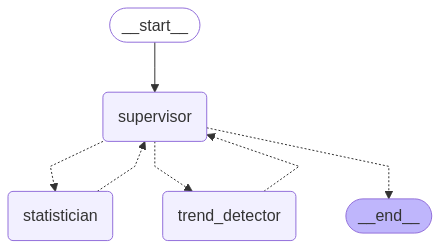

In [291]:
from IPython.display import Image, display
display(Image(compiled_data_analysis_graph.get_graph().draw_mermaid_png()))

Content Writing Team Graph

In [292]:
# 1. Create a StateGraph for the Content Writing Team
content_writing_graph = StateGraph(State)

# 2. Add nodes (Supervisor + Agents)
content_writing_graph.add_node("summarizer",summarizer_agent_node)

content_writing_graph.add_node("report_writer",report_writer_agent_node)

content_writing_graph.add_node("supervisor", content_writing_supervisor_node)

# 3. Define edges
content_writing_graph.add_edge(START, "supervisor")

# 4. Compile the graph
compiled_content_writing_graph = content_writing_graph.compile()

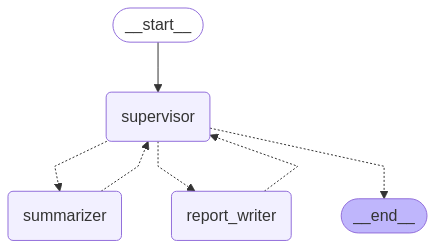

In [293]:
from IPython.display import Image, display
display(Image(compiled_content_writing_graph.get_graph().draw_mermaid_png()))

Define the Top-Level Supervisor Node

In [294]:
# Top-Level Supervisor Members
top_team_members = ["data_analysis_team", "content_writing_team"]
top_team_options = top_team_members + ["FINISH"]
class Router(TypedDict):
     """Worker to route to next. If no workers needed, route to FINISH."""
     next: Literal["data_analysis_team", "content_writing_team", "FINISH"]
# Create Top Supervisor Node
# top_supervisor_node = make_supervisor_node(ollama_model, top_team_members)
class State(MessagesState):
    next: str
    remaining_steps: RemainingSteps
    data_analysis_completed: bool = False

def top_supervisor_node(state: State) -> Command[Literal["data_analysis_team", "content_writing_team", "__end__"]]:
    if state["remaining_steps"] <= 2:
        return Command(goto=END)
    if state.get("data_analysis_completed", False):
            allowed_workers = ["content_writing_team"]
    else:
        allowed_workers = ["data_analysis_team"]

    system_prompt = (
            f"You are a Supervisor coordinating teams: {top_team_members}.\n"
            f"Allowed team(s) you can call now: {allowed_workers}\n"
            "First, call 'call_data_analysis_team'. Only after it completes, call 'call_content_writing_team'.\n"
            "After both teams have completed, respond with 'FINISH'."
        )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = ollama_model.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    # ✅ Forcefully intercept illegal moves:
    if goto not in allowed_workers:
        # If LLM made an illegal choice, overwrite manually
        goto = allowed_workers[0]

    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

Call Data Analysis Team

In [295]:
def call_data_analysis_team(state: State) -> Command[Literal["supervisor"]]:
    response = compiled_data_analysis_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={"messages": [HumanMessage(content=response["messages"][-1].content, name="data_analysis_team")],"data_analysis_completed": True},
        goto="supervisor"
    )


Call Content Writing Team

In [296]:
def call_content_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = compiled_content_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={"messages": [HumanMessage(content=response["messages"][-1].content, name="content_writing_team")]},
        goto="supervisor"
    )


3. Build the Final StateGraph

In [297]:
# 1. Create a new StateGraph for the full system
final_graph = StateGraph(State)

# 2. Add Top Supervisor and Subteams as nodes
final_graph.add_node("supervisor", top_supervisor_node)
final_graph.add_node("data_analysis_team", call_data_analysis_team)
final_graph.add_node("content_writing_team", call_content_writing_team)

# 3. Define edges
final_graph.add_edge(START, "supervisor")

# 4. Compile the final graph
compiled_final_graph = final_graph.compile()


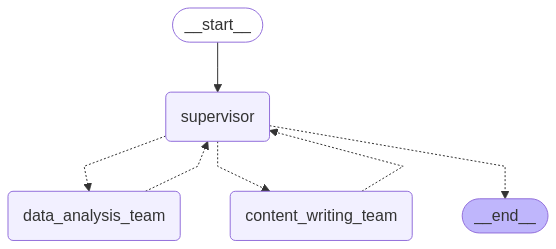

In [298]:
from IPython.display import Image, display

display(Image(compiled_final_graph.get_graph().draw_mermaid_png()))

In [299]:
# Run the compiled final graph
for step in compiled_final_graph.stream(
    {"messages": [("user", "sales data: [95, 102, 110, 120, 130, 145, 160].First, calculate the basic statistics like mean, median, and mode.Then, check if there is any clear trend in the sales pattern.After that, summarize the findings in bullet points and create a detailed market research report."

)]},
    {"recursion_limit": 15}  # Avoid infinite loops
):
    print(step)
    print("---")


{'supervisor': {'next': 'data_analysis_team'}}
---
{'data_analysis_team': {'messages': [HumanMessage(content='Here are the findings in bullet points:\n\n* Mean sales figure: $123.14\n* Median sales figure: $120\n* Mode sales figure: $95 (highest frequency)\n* Trend analysis: No clear trend detected, but sales appear to be increasing with fluctuations. May be affected by seasonal or external factors.\n\nDetailed Market Research Report:\n\nThe sales data for the given period shows a moderate increase in sales figures. The mean sales figure is $123.14, indicating a steady growth in revenue. However, the median sales figure of $120 suggests that there may be some fluctuation in sales patterns.\n\nInterestingly, the mode sales figure is $95, which indicates that this price point has the highest frequency of occurrence. This could suggest that there is a strong demand for products priced at $95.\n\nThe trend analysis reveals that there is no clear trend detected in the sales data. The sales 